This is a simple proof of concept of how we can apply basic nltk techniques to perform sentiment analysis of The Message (MSG) translation of the bible leveraging tensorflow.

High level approach:

* Create an array of the most frequntly occuring words from the negative and positive training data sets, aka [bag of words](https://machinelearningmastery.com/gentle-introduction-bag-words-model/) model and [lemmatize](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) them, i.e. converting them into their simplest form.
* Create feature/label set for positive and negative sentiment data by counting the number of popular words in each sample, from the array created above
* Using the above labelled features as inputs, train a 3 layer feedfoward neural network which will output an array containing probability percentages for True and False
* We save the model for later use and later run it on the Bible (MSG) saving the results in a sqlite database

Note, the basis for this comes largely from [Rachit Mishra's tutorial](https://becominghuman.ai/deep-learning-using-tensorflow-and-nltk-analyzing-corpuss-sentiments-part-1-bec9d6c1051). I amended it with the following:

* added a method to create the layers of the neural network
* saved the model after training for later re-use
* logged training results to be able to view in tensorboard
* ran the model on every verse books of the bible
* saved the results of the above predictions to a sqlite db
* created summary graphs of results

Also note that the training data comes from a movie review corpus so the accuracy of results against one of the oldest texts in history are questionable at best, even though I use a modern translation of the bible (MSG)

Let's start with some module imports, setup the logger to be able to toggle debug output which is a much better practice than littering with print statements, and initialize the lemmatizer object.

In [145]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import numpy as np
import random
import json
from collections import Counter
import tensorflow as tf
import numpy as np
import time
import sqlite3

# Setup output logging to give us better visibility into progress
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

# Instatiate a lemmatizer to use in creating the word stem set
lemmatizer = WordNetLemmatizer()

Let's define a method, `create_lexicon()`, which will comb through all of our positive and negative training data to extract the most frequently used words which appear at least 50 times. These will be converted into their simplified forms and then duplicates will be removed.

It would first convert this:
```
Hello this is a test. Hello world. The sky is grey today and my clown hair is red.
The cats wearing red hats sit back on the mat and put down like a clown who doesn't frown.
The sky is maybe not so grey but actually more red, like blood, like cat blood.
Tomorrow I will drink lots of black coffee mixed with gallons of paint.
```

into this: (note how some words have been converted from plural to singular)
```
['hello', 'this', 'is', 'a', 'test', 'hello', 'world', 'the', 'sky', 'is', 'grey', 'today', 'and', 'my', 'clown', 'hair', 'is', 'red', 'the', 'cat', 'wearing', 'red', 'hat', 'sit', 'back', 'on', 'the', 'mat', 'and', 'put', 'down', 'like', 'a', 'clown', 'who', 'doe', 'frown', 'the', 'sky', 'is', 'maybe', 'not', 'so', 'grey', 'but', 'actually', 'more', 'red', 'like', 'blood', 'like', 'cat', 'blood', 'tomorrow', 'i', 'will', 'drink', 'lot', 'of', 'black', 'coffee', 'mixed', 'with', 'gallon', 'of', 'paint']
```

and counting the words that only appear at least N times, if N=2:
```
['clown', 'a', 'sky', 'and', 'hello', 'of', 'is', 'blood', 'the', 'like', 'grey', 'red', 'cat']
```

which will become our reference lexicon array for creating feature maps during training and actual usage. We can also consider removing [stop words](https://pythonprogramming.net/stop-words-nltk-tutorial/) like "is","the","are" but in our case I found that our model accuracy actually decreased. This makes some sense in that we're trying to analyze the Bible, words like He and Him are probably more important than they are on regular texts.

In [157]:
def create_lexicon(pos, neg, filename=None):
    """Create unique list of most frequently used words 
    (occuring more than 50 times) from negative
    and postive corpus
    """
    lexicon = []
    for file in [pos, neg]:
        with open(file, 'r') as f:
            contents = f.readlines()
            for l in contents:
                all_words = word_tokenize(l.lower())  # split words into list
                lexicon += list(all_words)

    # lemmatize (simplify) all these words into their core form
    lexicon = [lemmatizer.lemmatize(i) for i in lexicon]
    lexicon = [ word for word in lexicon if word.isalpha() ]
    # Could also append "and word not in stopwords.words('english')" to the above
    # if we want to drop stop words
    w_counts = Counter(lexicon)
    final = [ word for word in w_counts if 1000 > w_counts[word] > 50 ]
    
    if filename:
        logger.debug('writing lexicon to {0}'.format(filename))
        with open(filename, 'w') as lexifile:
            json.dump(final, lexifile)
            
    logger.debug('lexicon contains {0} words'.format(len(final)))
    logger.debug('First 25 words:')
    logger.debug(lexicon[:25])
    return final


We'll need a way to convert our input phrases and sentences into feature arrays, `encode_features()`. Taking our previous example:

### lexicon
```
['clown', 'a', 'sky', 'and', 'hello', 'of', 'is', 'blood', 'the', 'like', 'grey', 'red', 'cat']
```

### input phrase
```
"The blood of a calf is red like the dark sky."
```

gets encoded as:

### output feature array
```
[0, 0, 1, 0, 0, 0, 1, 1, 2, 1, 0, 1, 0]
```

In [ ]:
def encode_features(phrase, lexicon):
    """Given an input phrase, return an array of
    the number of occurences of words from the
    lexicon list created prior
    """
    current_words = word_tokenize(phrase.lower())
    current_words = [lemmatizer.lemmatize(i) for i in current_words]
    features = np.zeros(len(lexicon))
    for word in current_words:
        if word.lower() in lexicon:
            index_value = lexicon.index(word.lower())
            features[index_value] += 1
    features = list(features)
    
    return features

Now we need to split our training data into training and testing groups so Tensoflow can validate its results. We'll also encode it with the above method and label it "(1,0)" for positive and "(0,1") for negative.

In [168]:
def create_feature_sets_and_labels(pos, neg, test_size=0.1):
    """Take positive and negative sentiment files and
    generate a list of features and labels from the
    positive and negative sentiment data using the methods
    above
    """
    
    # Create frequently occuring word list
    lexicon = create_lexicon(pos, neg, 'lexicon.json')
    featureset = []
    
    for sentiment_file, sentiment in ((pos, (1,0)),(neg, (0,1))):
        with open(sentiment_file, 'r') as f:
            contents = f.readlines()
        
        for line in contents:
            featureset.append((encode_features(line, lexicon), sentiment))
    
    featureset = list(featureset)
    random.shuffle(featureset)
    logger.debug('features length is {}'.format(len(featureset)))
    #logger.debug('First 5 features & labels:\n{0}'.format(featureset[:5]))
    
    featureset = np.array(featureset)
    testing_size = int(test_size * len(featureset))
    
    # x is features, y is labels
    train_x = list(featureset[:, 0][:-testing_size])
    train_y = list(featureset[:, 1][:-testing_size])

    test_x = list(featureset[:, 0][:-testing_size:])
    test_y = list(featureset[:, 1][:-testing_size:])

    return train_x, train_y, test_x, test_y, lexicon

# Create the train/test groups
train_x, train_y, test_x, test_y, lexicon = create_feature_sets_and_labels('pos.txt', 'neg.txt')

DEBUG:__main__:writing lexicon to lexicon.json
DEBUG:__main__:lexicon contains 406 words
DEBUG:__main__:First 25 words:
DEBUG:__main__:['the', 'rock', 'is', 'destined', 'to', 'be', 'the', 'century', 'new', 'conan', 'and', 'that', 'he', 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'arnold', 'schwarzenegger', 'van', 'damme']
DEBUG:__main__:features length is 10662


In [169]:
# Conduct the actual training

tf.reset_default_graph()

# Define number of nodes (500) across 3 hidden layers
n_nodes_hl1 = 500
n_nodes_hl2 = 500
n_nodes_hl3 = 500
n_classes = 2

batch_size = 100  # can do batches of 100 features at a time

# Create a placeholder to accept our training set created
# above and referenced on line 82 below
x = tf.placeholder('float', [None, len(train_x[0])], name='x')  # [None by length of lexicon]
# Create a labels placeholder again created above and
# referenced on line 82
y = tf.placeholder('float')

def linear(X, n_input, n_output, activation=None, scope=None):
    """Function to setup a basic neural network taking inputs
    and producing outputs according to W * x + b all wrapped
    by an activation function if defined"""
    with tf.variable_scope(scope or "linear"):
        W = tf.get_variable(
            name='W',
            shape=[n_input, n_output],
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.1))
        b = tf.get_variable(
            name='b',
            shape=[n_output],
            initializer=tf.constant_initializer())
        h = tf.matmul(X, W) + b
        if activation is not None:
            h = activation(h)
        return h

def neural_network(data):
    # layer 1 takes a phrase of text as input and outputs a matrix of size 500
    h1 = linear(data, len(train_x[0]), n_nodes_hl1, tf.nn.relu, scope='layer1')
    # layer 2 takes the output from above and spits out another matrix of size [500]
    h2 = linear(h1, n_nodes_hl1, n_nodes_hl2, tf.nn.relu, scope='layer2')
    # layer 3 (does the same as layer 2)
    h3 = linear(h2, n_nodes_hl2, n_nodes_hl3, tf.nn.relu, scope='layer3')
    # output layer takes the output from layer 3 and reduces it down to a matrix
    # containing 2 values [percentage positive, percentage negative]
    output = linear(h3, n_nodes_hl3, n_classes, None, scope='output')
    return output

def train_neural_network(x):
    prediction = neural_network(x)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y))

    # AdamOptimizer seems to automatically adjust the learning rate as opposed to
    # GradientDescent's fixed
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cost)

    # Create a saver object to save our graph
    saver = tf.train.Saver()
    
    n_epochs = 10

    tf.summary.scalar("cost", cost)
    summary_op = tf.summary.merge_all()
    
    with tf.Session() as sess:
        
        writer = tf.summary.FileWriter('summary/log', graph=sess.graph)
        sess.run(tf.global_variables_initializer())  # initializes our variables. Session has now begun.

        for epoch in range(n_epochs):
            epoch_loss = 0  # we'll calculate the loss as we go

            i = 0
            while i < len(train_x):
                #we want to take batches(chunks); take a slice, then another size)
                start = i
                end = i+batch_size

                batch_x = np.array(train_x[start:end])
                batch_y = np.array(train_y[start:end])
                _, c, summary = sess.run([optimizer, cost, summary_op], feed_dict={x: batch_x, y: batch_y})
                
                # write log to view stats in tensorboard
                writer.add_summary(summary, epoch * n_epochs + i)
                
                # Create a checkpoint in every iteration
                #saver.save(sess, 'model/model_iter', global_step=epoch)
                
                epoch_loss += c
                i+=batch_size

            print('Epoch', epoch, 'completed out of', n_epochs, 'loss:', epoch_loss)

        pred_op = tf.nn.softmax(prediction, name='pred_op')
        # Save the final model
        saver.save(sess, 'model/model_final')
        
        correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
        tf.summary.scalar("accuracy", accuracy)
        
        print('Accuracy:', accuracy.eval({x: test_x, y: test_y}))
        
        # Run classification against data
        feed_dict = {x: np.array([test_x[35]]).astype('float32')}
        sentiment = sess.run(tf.nn.softmax(prediction), feed_dict)
        print('sentiment is {}'.format(sentiment))

train_neural_network(x)

Epoch 0 completed out of 10 loss: 64.5960595012
Epoch 1 completed out of 10 loss: 45.2602910995
Epoch 2 completed out of 10 loss: 30.1446892172
Epoch 3 completed out of 10 loss: 19.8478845358
Epoch 4 completed out of 10 loss: 23.3400688022
Epoch 5 completed out of 10 loss: 19.7552281469
Epoch 6 completed out of 10 loss: 13.5674309283
Epoch 7 completed out of 10 loss: 10.8786701597
Epoch 8 completed out of 10 loss: 8.56252970174
Epoch 9 completed out of 10 loss: 8.28067351319
Accuracy: 0.963422
sentiment is [[ 0.00291243  0.99708754]]


In [20]:
# Load and use model

def run_prediction(book):
    # Parse in MSG bible
    with open('MSG.json','r') as foo:
        msg = foo.read()
        msg = json.loads(msg)
    
    with open('lexicon.json','r') as foo:
        lexicon = foo.read()
        lexicon = json.loads(lexicon)
    
    tf.reset_default_graph()
    
    with tf.Session() as sess:
        # Create a saver object to save our graph
        saver = tf.train.import_meta_graph('model/model_final.meta')
        saver.restore(sess, tf.train.latest_checkpoint('model/'))
        #sess.run(tf.global_variables_initializer())  # initializes our variables. Session has now begun.

        # Get default graph (supply your custom graph if you have one)
        graph = tf.get_default_graph()
        #for name in [n.name for n in graph.as_graph_def().node]:
        #    print(name)
        
        x = graph.get_tensor_by_name("x:0")
        pred_op = graph.get_tensor_by_name("pred_op:0")
        
        verses = []
        
        '''
        sqlite> .schema bible
        CREATE TABLE bible (book text, chapter int, verse int, sentiment int, pos real, neg real);
        '''

        conn = sqlite3.connect('bible.db')
        c = conn.cursor()
                
        print('# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)')
        
        num = 0
        epoch = int(time.time())
        
        for chap in msg[book]:
            for verse in msg[book][chap].items():
                verse_info = {'chapter': chap,
                              'verse': verse[0],
                              'content': verse[1]}
                try:
                    verse_info['content'] = np.array([encode_features(verse_info['content'], lexicon)]).astype('float32')
                    feed_dict = {x: verse_info['content']}
                    sentiment = sess.run(tf.nn.softmax(pred_op), feed_dict)
                    negpos = {0:'negative', 1:'positive'}
                    summary = (book,
                               int(verse_info['chapter']),
                               int(verse_info['verse']),
                               int(sess.run(tf.argmin(sentiment,1))),
                               sentiment.tolist()[0][0],
                               sentiment.tolist()[0][1]
                              )

                    if num % 10 == 0:
                        cur_epoch = int(time.time())
                        delta_epoch = cur_epoch - epoch
                        epoch = cur_epoch
                        print(summary,delta_epoch)                     
                    num += 1

                    c.execute('INSERT INTO bible VALUES (?,?,?,?,?,?)', summary)
                except:
                    print(verse_info['content'])
        conn.commit()
        conn.close()

        
bible = ( '1 Kings', 'Colossians', '2 Corinthians', '2 Chronicles', 'Habakkuk', '1 Samuel',
 'Acts', 'Psalms', 'Hosea', 'Daniel', 'James','Zechariah', 'Jonah', '1 Chronicles',
 'Nehemiah', 'Romans', 'Micah', 'Isaiah', 'Jude', '2 Kings', '1 Corinthians', '2 John',
 '3 John', 'Leviticus', '1 Peter', 'John', 'Nahum', 'Luke', 'Obadiah', 'Ephesians',
 '1 Thessalonians', 'Galatians', 'Ezekiel', '2 Peter', 'Song of Solomon',
 '1 Timothy','Haggai', 'Esther', '2 Timothy', 'Exodus', 'Joel', 'Philippians', 'Judges', 'Titus',
 'Amos', '1 John', 'Mark', 'Genesis', 'Jeremiah', 'Numbers', 'Revelation', 'Ezra')

for book in bible:
    run_prediction(book)

INFO:tensorflow:Restoring parameters from model/model_final


INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('1 Kings', 22, 48, 1, 0.7301628589630127, 0.2698371708393097) 0
('1 Kings', 22, 16, 0, 0.2689419388771057, 0.7310581207275391) 1
('1 Kings', 22, 36, 1, 0.5065181851387024, 0.49348175525665283) 0
('1 Kings', 22, 6, 1, 0.5343984961509705, 0.46560147404670715) 0
('1 Kings', 22, 43, 0, 0.2689417004585266, 0.7310582995414734) 1
('1 Kings', 22, 13, 0, 0.26902079582214355, 0.7309791445732117) 0
('1 Kings', 21, 2, 1, 0.7003198862075806, 0.29968008399009705) 0
('1 Kings', 21, 7, 0, 0.2689483165740967, 0.7310516834259033) 1
('1 Kings', 21, 23, 0, 0.28493088483810425, 0.7150691151618958) 0
('1 Kings', 6, 14, 0, 0.4769875705242157, 0.5230124592781067) 0
('1 Kings', 6, 32, 1, 0.7295066118240356, 0.27049335837364197) 1
('1 Kings', 6, 18, 1, 0.7309094071388245, 0.26909053325653076) 0
('1 Kings', 11, 6, 1, 0.5146255493164062, 0.4853745102882385) 1
('1 Kings', 11, 1, 0, 0.26983946561813354, 0.7301604747772217) 0
('1 Kings', 11, 7

INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Colossians', 3, 22, 0, 0.3153419494628906, 0.6846579909324646) 0
('Colossians', 3, 9, 1, 0.7029757499694824, 0.29702427983283997) 0
('Colossians', 3, 12, 0, 0.2689436376094818, 0.7310563921928406) 1
('Colossians', 2, 10, 1, 0.7310583591461182, 0.26894161105155945) 0
('Colossians', 2, 7, 0, 0.2689414322376251, 0.7310585975646973) 0
('Colossians', 1, 6, 0, 0.3082309663295746, 0.6917690634727478) 1
('Colossians', 1, 16, 0, 0.2689417004585266, 0.7310582995414734) 0
('Colossians', 1, 29, 0, 0.4380766451358795, 0.5619233846664429) 0
('Colossians', 4, 11, 1, 0.7296137809753418, 0.2703862190246582) 1
('Colossians', 4, 3, 1, 0.7310153841972351, 0.26898452639579773) 0
INFO:tensorflow:Restoring parameters from model/model_final


INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('2 Corinthians', 5, 5, 1, 0.7244736552238464, 0.2755263149738312) 0
('2 Corinthians', 5, 14, 1, 0.731055736541748, 0.26894429326057434) 1
('2 Corinthians', 7, 7, 0, 0.2700120508670807, 0.7299879193305969) 0
('2 Corinthians', 7, 1, 1, 0.7307299971580505, 0.26927000284194946) 0
('2 Corinthians', 6, 10, 0, 0.2689759135246277, 0.7310240864753723) 1
('2 Corinthians', 6, 13, 1, 0.548064649105072, 0.451935350894928) 0
('2 Corinthians', 11, 2, 0, 0.2700953781604767, 0.7299046516418457) 0
('2 Corinthians', 11, 17, 1, 0.548297107219696, 0.45170286297798157) 1
('2 Corinthians', 11, 12, 0, 0.26894378662109375, 0.731056272983551) 0
('2 Corinthians', 10, 15, 1, 0.7189077138900757, 0.2810922861099243) 1
('2 Corinthians', 10, 9, 0, 0.3321964740753174, 0.6678035259246826) 0
('2 Corinthians', 2, 2, 1, 0.5984526872634888, 0.40154728293418884) 0
('2 Corinthians', 2, 17, 1, 0.6832706332206726, 0.3167293071746826) 1
('2 Corinthians', 

INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('2 Chronicles', 22, 5, 0, 0.26901549100875854, 0.7309844493865967) 1
('2 Chronicles', 22, 3, 1, 0.7310569882392883, 0.2689429819583893) 0
('2 Chronicles', 21, 2, 1, 0.6981977224349976, 0.30180227756500244) 0
('2 Chronicles', 21, 19, 1, 0.6274542808532715, 0.3725457489490509) 0
('2 Chronicles', 6, 10, 0, 0.4865456521511078, 0.5134543180465698) 1
('2 Chronicles', 6, 8, 0, 0.2697242796421051, 0.7302756905555725) 0
('2 Chronicles', 6, 15, 0, 0.26949062943458557, 0.7305094003677368) 0
('2 Chronicles', 6, 20, 1, 0.7232386469841003, 0.27676132321357727) 1
('2 Chronicles', 11, 2, 1, 0.5061128735542297, 0.49388712644577026) 0
('2 Chronicles', 11, 15, 1, 0.5931496024131775, 0.4068504273891449) 1
('2 Chronicles', 24, 11, 0, 0.45057985186576843, 0.549420177936554) 0
('2 Chronicles', 24, 4, 1, 0.611968457698822, 0.388031542301178) 0
('2 Chronicles', 24, 18, 1, 0.7142688632011414, 0.28573116660118103) 1
('2 Chronicles', 19, 3,

INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Habakkuk', 3, 5, 0, 0.37605807185173035, 0.6239418983459473) 0
('Habakkuk', 3, 14, 0, 0.45848971605300903, 0.5415103435516357) 0
('Habakkuk', 2, 7, 1, 0.5979816913604736, 0.40201830863952637) 1
('Habakkuk', 2, 14, 1, 0.7029299736022949, 0.29707005620002747) 0
('Habakkuk', 1, 7, 0, 0.2689415216445923, 0.7310584783554077) 0
('Habakkuk', 1, 1, 1, 0.704631507396698, 0.2953684329986572) 1
INFO:tensorflow:Restoring parameters from model/model_final


INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('1 Samuel', 22, 22, 0, 0.2689414322376251, 0.7310585975646973) 0
('1 Samuel', 22, 1, 0, 0.29167839884757996, 0.7083215713500977) 0
('1 Samuel', 22, 20, 0, 0.2692401111125946, 0.7307599186897278) 0
('1 Samuel', 21, 4, 0, 0.269070029258728, 0.7309299111366272) 1
('1 Samuel', 6, 8, 0, 0.289638489484787, 0.7103615403175354) 0
('1 Samuel', 6, 14, 1, 0.7309251427650452, 0.26907485723495483) 0
('1 Samuel', 11, 7, 1, 0.7286837697029114, 0.2713162899017334) 0
('1 Samuel', 11, 1, 1, 0.713381290435791, 0.286618709564209) 1
('1 Samuel', 24, 3, 1, 0.7271091938018799, 0.2728908360004425) 0
('1 Samuel', 24, 15, 1, 0.7309837341308594, 0.26901620626449585) 0
('1 Samuel', 19, 24, 0, 0.27103203535079956, 0.7289680242538452) 1
('1 Samuel', 19, 8, 1, 0.7310585975646973, 0.2689414322376251) 0
('1 Samuel', 10, 22, 0, 0.2689616084098816, 0.7310383319854736) 1
('1 Samuel', 10, 9, 0, 0.3407377302646637, 0.6592622399330139) 0
('1 Samuel', 

INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Acts', 22, 22, 1, 0.7280205488204956, 0.271979421377182) 0
('Acts', 22, 9, 0, 0.3845359683036804, 0.6154639720916748) 0
('Acts', 22, 28, 0, 0.3930377960205078, 0.6069622039794922) 1
('Acts', 21, 22, 0, 0.26896294951438904, 0.7310370802879333) 0
('Acts', 21, 14, 0, 0.2693096399307251, 0.7306903600692749) 0
('Acts', 21, 39, 0, 0.26903483271598816, 0.7309651374816895) 1
('Acts', 21, 5, 1, 0.7305305004119873, 0.2694694697856903) 0
('Acts', 6, 5, 1, 0.5286808609962463, 0.47131916880607605) 0
('Acts', 6, 9, 1, 0.7310130000114441, 0.2689870297908783) 1
('Acts', 11, 19, 0, 0.2745082974433899, 0.7254917025566101) 0
('Acts', 11, 8, 1, 0.7107622027397156, 0.2892378270626068) 0
('Acts', 11, 12, 1, 0.6865615248680115, 0.3134385049343109) 1
('Acts', 24, 10, 1, 0.7310575842857361, 0.26894238591194153) 0
('Acts', 24, 17, 0, 0.26955991983413696, 0.7304400205612183) 1
('Acts', 24, 23, 1, 0.5980544686317444, 0.4019455313682556) 0


INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Psalms', 84, 5, 1, 0.6421083211898804, 0.35789164900779724) 0
('Psalms', 84, 3, 0, 0.3077470064163208, 0.692253053188324) 1
('Psalms', 1, 5, 0, 0.3704402446746826, 0.6295597553253174) 0
('Psalms', 149, 3, 1, 0.7309249043464661, 0.26907506585121155) 0
('Psalms', 48, 14, 1, 0.7244381308555603, 0.2755618989467621) 1
('Psalms', 96, 5, 0, 0.36235716938972473, 0.6376428604125977) 0
('Psalms', 96, 3, 0, 0.4739604890346527, 0.5260395407676697) 0
('Psalms', 108, 12, 1, 0.725577175617218, 0.27442285418510437) 1
('Psalms', 40, 15, 1, 0.730352520942688, 0.269647479057312) 0
('Psalms', 40, 13, 0, 0.420993447303772, 0.5790066123008728) 1
('Psalms', 91, 4, 0, 0.48300620913505554, 0.5169938206672668) 0
('Psalms', 139, 21, 1, 0.6504027843475342, 0.3495972156524658) 1
('Psalms', 139, 1, 0, 0.26934710144996643, 0.730652928352356) 0
('Psalms', 139, 20, 1, 0.6384455561637878, 0.36155444383621216) 1
('Psalms', 141, 8, 0, 0.2689414322

INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Hosea', 5, 5, 1, 0.5085428357124329, 0.4914572238922119) 0
('Hosea', 5, 9, 0, 0.2778419852256775, 0.7221580147743225) 0
('Hosea', 7, 10, 0, 0.2814226746559143, 0.7185772657394409) 1
('Hosea', 7, 8, 0, 0.4769875705242157, 0.5230124592781067) 0
('Hosea', 6, 10, 0, 0.2809808552265167, 0.7190191745758057) 0
('Hosea', 11, 9, 0, 0.2689417004585266, 0.7310582995414734) 0
('Hosea', 10, 2, 0, 0.3948286175727844, 0.6051713824272156) 1
('Hosea', 2, 21, 0, 0.487937867641449, 0.512062132358551) 0
('Hosea', 2, 16, 1, 0.7309668660163879, 0.26903313398361206) 0
('Hosea', 2, 13, 0, 0.2689414322376251, 0.7310585975646973) 1
('Hosea', 4, 4, 1, 0.718366265296936, 0.28163373470306396) 0
('Hosea', 4, 17, 0, 0.29952922463417053, 0.7004707455635071) 1
('Hosea', 12, 9, 0, 0.2689414322376251, 0.7310585975646973) 0
('Hosea', 14, 8, 0, 0.27824661135673523, 0.7217534184455872) 0
('Hosea', 9, 2, 0, 0.2689630091190338, 0.7310370206832886) 1
(

INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Daniel', 5, 22, 0, 0.27524280548095703, 0.724757194519043) 0
('Daniel', 5, 9, 1, 0.7310044765472412, 0.26899558305740356) 0
('Daniel', 5, 28, 1, 0.7309255003929138, 0.26907455921173096) 1
('Daniel', 5, 23, 0, 0.2692331373691559, 0.7307668328285217) 0
('Daniel', 7, 14, 1, 0.7310585975646973, 0.2689414322376251) 0
('Daniel', 7, 28, 1, 0.7310535311698914, 0.2689465284347534) 0
('Daniel', 6, 21, 0, 0.4769875705242157, 0.5230124592781067) 1
('Daniel', 6, 1, 1, 0.7109829783439636, 0.289016991853714) 0
('Daniel', 6, 15, 0, 0.3714287281036377, 0.6285712718963623) 0
('Daniel', 11, 2, 0, 0.26894280314445496, 0.7310572266578674) 1
('Daniel', 11, 25, 0, 0.26946091651916504, 0.730539083480835) 0
('Daniel', 11, 38, 0, 0.28384342789649963, 0.716156542301178) 1
('Daniel', 11, 27, 1, 0.5159897804260254, 0.484010249376297) 0
('Daniel', 11, 13, 1, 0.7310574650764465, 0.26894253492355347) 0
('Daniel', 10, 10, 1, 0.6716240644454956,

INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('James', 3, 5, 1, 0.7310517430305481, 0.2689482569694519) 0
('James', 3, 18, 1, 0.638466477394104, 0.361533522605896) 0
('James', 2, 6, 1, 0.7241637706756592, 0.2758362293243408) 1
('James', 2, 16, 0, 0.2694411277770996, 0.7305588126182556) 0
('James', 2, 18, 1, 0.6716639399528503, 0.32833603024482727) 0
('James', 1, 10, 0, 0.27572017908096313, 0.7242798805236816) 1
('James', 1, 17, 0, 0.3043597638607025, 0.6956402063369751) 0
('James', 1, 23, 1, 0.7309837937355042, 0.2690161466598511) 0
('James', 4, 14, 1, 0.7270928025245667, 0.27290719747543335) 1
('James', 5, 8, 1, 0.6868619918823242, 0.3131379783153534) 0
('James', 5, 18, 1, 0.7310436367988586, 0.26895639300346375) 1
INFO:tensorflow:Restoring parameters from model/model_final


INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Zechariah', 5, 2, 0, 0.26898378133773804, 0.7310161590576172) 0
('Zechariah', 5, 4, 0, 0.2690415680408478, 0.7309584617614746) 0
('Zechariah', 7, 9, 0, 0.4629722833633423, 0.5370277166366577) 0
('Zechariah', 6, 10, 0, 0.4664970934391022, 0.5335028767585754) 0
('Zechariah', 11, 5, 0, 0.26979902386665344, 0.7302008867263794) 1
('Zechariah', 11, 9, 1, 0.7244192361831665, 0.2755807936191559) 0
('Zechariah', 10, 11, 0, 0.3794832229614258, 0.6205167174339294) 0
('Zechariah', 2, 7, 1, 0.7301877737045288, 0.2698122262954712) 1
('Zechariah', 2, 13, 1, 0.6600884795188904, 0.3399115204811096) 0
('Zechariah', 4, 14, 0, 0.4706108868122101, 0.5293891429901123) 1
('Zechariah', 12, 10, 1, 0.7137027382850647, 0.2862972021102905) 0
('Zechariah', 14, 5, 0, 0.2689414322376251, 0.7310585975646973) 0
('Zechariah', 14, 3, 1, 0.7310138940811157, 0.2689861059188843) 1
('Zechariah', 14, 17, 1, 0.7308482527732849, 0.26915180683135986) 0
(

INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Jonah', 3, 2, 1, 0.7248449921607971, 0.2751550078392029) 0
('Jonah', 2, 2, 0, 0.26894518733024597, 0.7310548424720764) 0
('Jonah', 1, 5, 0, 0.41866108775138855, 0.5813389420509338) 0
('Jonah', 1, 9, 0, 0.270525723695755, 0.7294743061065674) 1
('Jonah', 4, 9, 1, 0.5932632088661194, 0.406736820936203) 0
INFO:tensorflow:Restoring parameters from model/model_final


INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('1 Chronicles', 22, 5, 0, 0.2704920768737793, 0.7295079231262207) 0
('1 Chronicles', 22, 14, 1, 0.616773247718811, 0.38322684168815613) 1
('1 Chronicles', 21, 21, 1, 0.6921765804290771, 0.30782341957092285) 0
('1 Chronicles', 21, 1, 1, 0.7112420797348022, 0.28875792026519775) 0
('1 Chronicles', 21, 26, 0, 0.27296093106269836, 0.7270389795303345) 0
('1 Chronicles', 6, 15, 0, 0.27713173627853394, 0.7228682041168213) 1
('1 Chronicles', 6, 3, 1, 0.708884060382843, 0.291115939617157) 0
('1 Chronicles', 6, 17, 0, 0.4132321774959564, 0.5867677927017212) 0
('1 Chronicles', 6, 6, 1, 0.7310578227043152, 0.2689421772956848) 1
('1 Chronicles', 6, 41, 0, 0.4769875705242157, 0.5230124592781067) 0
('1 Chronicles', 6, 74, 1, 0.689784586429596, 0.31021541357040405) 1
('1 Chronicles', 6, 2, 1, 0.6981977224349976, 0.30180227756500244) 0
('1 Chronicles', 6, 18, 1, 0.6981977224349976, 0.30180227756500244) 0
('1 Chronicles', 11, 11, 1

INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Nehemiah', 5, 5, 1, 0.7285148501396179, 0.27148517966270447) 0
('Nehemiah', 5, 14, 0, 0.3410245478153229, 0.6589754223823547) 1
('Nehemiah', 7, 15, 0, 0.4769875705242157, 0.5230124592781067) 0
('Nehemiah', 7, 14, 0, 0.4769875705242157, 0.5230124592781067) 0
('Nehemiah', 7, 5, 0, 0.26915639638900757, 0.7308436632156372) 1
('Nehemiah', 7, 57, 1, 0.704318642616272, 0.295681357383728) 0
('Nehemiah', 7, 54, 0, 0.4769875705242157, 0.5230124592781067) 1
('Nehemiah', 7, 27, 0, 0.4769875705242157, 0.5230124592781067) 0
('Nehemiah', 7, 51, 0, 0.4769875705242157, 0.5230124592781067) 0
('Nehemiah', 7, 61, 1, 0.7018283605575562, 0.29817160964012146) 1
('Nehemiah', 6, 4, 1, 0.7285557389259338, 0.27144426107406616) 0
('Nehemiah', 6, 17, 1, 0.511620819568634, 0.4883791506290436) 1
('Nehemiah', 11, 14, 1, 0.6295605301856995, 0.3704395294189453) 0
('Nehemiah', 11, 7, 1, 0.6327828764915466, 0.3672170639038086) 1
('Nehemiah', 11, 1

INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Romans', 5, 5, 0, 0.3764752447605133, 0.6235247850418091) 0
('Romans', 5, 3, 1, 0.7310200333595276, 0.26897993683815) 1
('Romans', 5, 17, 1, 0.7310584783554077, 0.2689415216445923) 1
('Romans', 7, 14, 0, 0.2689414322376251, 0.7310585975646973) 0
('Romans', 7, 5, 1, 0.5939890742301941, 0.4060108959674835) 1
('Romans', 6, 10, 0, 0.34456565976142883, 0.6554343700408936) 0
('Romans', 6, 8, 0, 0.28099289536476135, 0.719007134437561) 1
('Romans', 11, 6, 0, 0.28582918643951416, 0.7141708135604858) 0
('Romans', 11, 16, 1, 0.6712723970413208, 0.3287276327610016) 0
('Romans', 11, 26, 0, 0.2756043076515198, 0.7243956923484802) 1
('Romans', 11, 34, 0, 0.269148051738739, 0.7308520078659058) 0
('Romans', 15, 10, 1, 0.7073246836662292, 0.29267534613609314) 1
('Romans', 15, 27, 1, 0.7281379699707031, 0.2718620300292969) 0
('Romans', 15, 5, 0, 0.2698756456375122, 0.7301244139671326) 1
('Romans', 10, 21, 0, 0.49853411316871643, 0

INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Micah', 2, 5, 1, 0.6995745897293091, 0.3004254102706909) 0
('Micah', 2, 3, 0, 0.26908233761787415, 0.7309176325798035) 0
('Micah', 4, 12, 0, 0.2689414322376251, 0.7310585975646973) 0
('Micah', 7, 4, 0, 0.28399786353111267, 0.7160021662712097) 1
('Micah', 7, 16, 1, 0.7070052623748779, 0.29299476742744446) 0
('Micah', 1, 15, 1, 0.7309113144874573, 0.2690886855125427) 0
('Micah', 1, 13, 0, 0.27881723642349243, 0.7211828231811523) 1
('Micah', 5, 12, 0, 0.2690291404724121, 0.7309707999229431) 0
('Micah', 3, 11, 1, 0.7303616404533386, 0.2696383595466614) 0
('Micah', 6, 7, 1, 0.7294865846633911, 0.2705133855342865) 1
('Micah', 6, 1, 0, 0.26894229650497437, 0.7310577034950256) 0
INFO:tensorflow:Restoring parameters from model/model_final


INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Isaiah', 66, 22, 0, 0.2689415216445923, 0.7310584783554077) 0
('Isaiah', 66, 9, 1, 0.7266416549682617, 0.2733582854270935) 1
('Isaiah', 66, 18, 1, 0.687695324420929, 0.31230470538139343) 0
('Isaiah', 15, 5, 0, 0.3756462335586548, 0.62435382604599) 0
('Isaiah', 48, 14, 0, 0.2699924111366272, 0.7300075888633728) 1
('Isaiah', 48, 5, 0, 0.26903992891311646, 0.7309601306915283) 0
('Isaiah', 11, 10, 1, 0.6923733353614807, 0.3076266348361969) 0
('Isaiah', 11, 8, 0, 0.2698069214820862, 0.730193018913269) 1
('Isaiah', 35, 4, 1, 0.7310322523117065, 0.26896774768829346) 0
('Isaiah', 19, 14, 1, 0.7290603518486023, 0.27093958854675293) 1
('Isaiah', 19, 5, 1, 0.525678277015686, 0.47432175278663635) 0
('Isaiah', 22, 24, 1, 0.6580803394317627, 0.3419196307659149) 0
('Isaiah', 22, 8, 0, 0.29401516914367676, 0.7059847712516785) 1
('Isaiah', 22, 23, 0, 0.2721835672855377, 0.7278164625167847) 0
('Isaiah', 46, 1, 0, 0.26897007226943

INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Jude', 1, 22, 1, 0.5594998002052307, 0.4405001997947693) 0
('Jude', 1, 9, 0, 0.2731236219406128, 0.7268763184547424) 0
('Jude', 1, 12, 0, 0.2689414322376251, 0.7310585975646973) 0
INFO:tensorflow:Restoring parameters from model/model_final


INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('2 Kings', 22, 5, 1, 0.7260441184043884, 0.2739558219909668) 1
('2 Kings', 22, 12, 1, 0.5240616798400879, 0.47593826055526733) 0
('2 Kings', 21, 22, 0, 0.4187028706073761, 0.5812970995903015) 0
('2 Kings', 21, 9, 1, 0.7307702302932739, 0.2692297697067261) 0
('2 Kings', 21, 5, 1, 0.7168043851852417, 0.2831956446170807) 1
('2 Kings', 6, 24, 1, 0.7272281050682068, 0.2727718949317932) 0
('2 Kings', 6, 30, 0, 0.3303650915622711, 0.6696348786354065) 0
('2 Kings', 6, 15, 1, 0.6817269325256348, 0.3182730972766876) 1
('2 Kings', 11, 21, 0, 0.2817738950252533, 0.7182261347770691) 0
('2 Kings', 11, 16, 0, 0.2762867510318756, 0.723713219165802) 1
('2 Kings', 24, 6, 1, 0.6961820125579834, 0.303818017244339) 0
('2 Kings', 24, 1, 1, 0.7310584187507629, 0.2689415514469147) 1
('2 Kings', 19, 11, 0, 0.2822938561439514, 0.7177061438560486) 0
('2 Kings', 19, 4, 0, 0.2689414322376251, 0.7310585975646973) 1
('2 Kings', 19, 31, 1, 0.68

INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('1 Corinthians', 5, 5, 1, 0.7310470342636108, 0.26895296573638916) 0
('1 Corinthians', 5, 3, 0, 0.2689414322376251, 0.7310585975646973) 0
('1 Corinthians', 7, 10, 0, 0.44864070415496826, 0.5513592958450317) 1
('1 Corinthians', 7, 27, 0, 0.2873896658420563, 0.7126103639602661) 0
('1 Corinthians', 7, 36, 1, 0.7296518683433533, 0.2703481912612915) 0
('1 Corinthians', 7, 13, 0, 0.29239320755004883, 0.7076067924499512) 0
('1 Corinthians', 6, 10, 1, 0.7288987636566162, 0.2711012363433838) 1
('1 Corinthians', 6, 13, 0, 0.26894915103912354, 0.7310508489608765) 0
('1 Corinthians', 11, 1, 0, 0.27678731083869934, 0.723212718963623) 1
('1 Corinthians', 11, 26, 1, 0.7310585975646973, 0.2689414322376251) 0
('1 Corinthians', 11, 13, 0, 0.26894325017929077, 0.7310567498207092) 0
('1 Corinthians', 15, 9, 1, 0.7307692766189575, 0.2692307233810425) 1
('1 Corinthians', 15, 26, 1, 0.7290487885475159, 0.27095121145248413) 0
('1 Corint

INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('2 John', 1, 5, 0, 0.2738712430000305, 0.7261287569999695) 0
('2 John', 1, 3, 1, 0.648795485496521, 0.35120445489883423) 0
INFO:tensorflow:Restoring parameters from model/model_final


INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('3 John', 1, 5, 0, 0.2718428671360016, 0.7281571626663208) 0
('3 John', 1, 1, 0, 0.268966943025589, 0.7310329675674438) 1
INFO:tensorflow:Restoring parameters from model/model_final


INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Leviticus', 22, 22, 1, 0.7304279208183289, 0.2695721387863159) 0
('Leviticus', 22, 9, 0, 0.4427030682563782, 0.5572969913482666) 0
('Leviticus', 22, 25, 0, 0.26908865571022034, 0.7309113144874573) 0
('Leviticus', 22, 20, 1, 0.7309539318084717, 0.26904603838920593) 1
('Leviticus', 21, 2, 0, 0.4769875705242157, 0.5230124592781067) 0
('Leviticus', 21, 15, 0, 0.2698267102241516, 0.7301732897758484) 0
('Leviticus', 6, 11, 1, 0.7279284000396729, 0.27207162976264954) 1
('Leviticus', 6, 4, 0, 0.2689869999885559, 0.7310130000114441) 0
('Leviticus', 6, 29, 1, 0.6705911159515381, 0.3294088542461395) 0
('Leviticus', 11, 2, 0, 0.26901596784591675, 0.730984091758728) 1
('Leviticus', 11, 8, 0, 0.27126753330230713, 0.7287324070930481) 0
('Leviticus', 11, 44, 0, 0.26898008584976196, 0.7310198545455933) 1
('Leviticus', 11, 4, 0, 0.29757314920425415, 0.7024269104003906) 0
('Leviticus', 11, 18, 0, 0.4769875705242157, 0.523012459278

INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('1 Peter', 3, 22, 0, 0.3756847381591797, 0.6243152618408203) 0
('1 Peter', 3, 16, 1, 0.7289982438087463, 0.27100178599357605) 0
('1 Peter', 3, 20, 0, 0.2689414322376251, 0.7310585975646973) 1
('1 Peter', 2, 3, 1, 0.7300593256950378, 0.26994070410728455) 0
('1 Peter', 2, 15, 0, 0.2689443826675415, 0.7310556769371033) 0
('1 Peter', 1, 11, 0, 0.37830212712287903, 0.6216979026794434) 1
('1 Peter', 1, 4, 1, 0.5898876190185547, 0.4101123809814453) 0
('1 Peter', 1, 13, 0, 0.26903650164604187, 0.7309634685516357) 0
('1 Peter', 4, 4, 1, 0.7220541834831238, 0.2779458463191986) 1
('1 Peter', 4, 17, 1, 0.7255582213401794, 0.27444183826446533) 0
('1 Peter', 5, 9, 1, 0.6382061839103699, 0.3617938160896301) 0
INFO:tensorflow:Restoring parameters from model/model_final


INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('John', 5, 11, 0, 0.269149512052536, 0.7308504581451416) 0
('John', 5, 31, 0, 0.27018073201179504, 0.7298192977905273) 0
('John', 5, 37, 1, 0.7249785661697388, 0.27502143383026123) 0
('John', 5, 45, 1, 0.7233597040176392, 0.27664029598236084) 0
('John', 5, 29, 1, 0.7310459613800049, 0.26895394921302795) 1
('John', 7, 46, 1, 0.7267611026763916, 0.273238867521286) 0
('John', 7, 19, 0, 0.4140567481517792, 0.5859432220458984) 0
('John', 7, 30, 1, 0.7307800650596619, 0.26921993494033813) 1
('John', 7, 40, 1, 0.7152529358863831, 0.28474703431129456) 0
('John', 7, 28, 1, 0.721646249294281, 0.2783537805080414) 0
('John', 8, 11, 1, 0.7310402393341064, 0.26895973086357117) 1
('John', 8, 16, 1, 0.7107269167900085, 0.28927308320999146) 0
('John', 8, 15, 1, 0.7036455869674683, 0.29635438323020935) 1
('John', 8, 41, 0, 0.2723936140537262, 0.7276064157485962) 0
('John', 8, 52, 0, 0.2689449191093445, 0.7310550212860107) 0
('John

INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Nahum', 3, 5, 0, 0.2689414322376251, 0.7310585975646973) 0
('Nahum', 3, 14, 0, 0.2690501809120178, 0.7309498190879822) 0
('Nahum', 2, 7, 0, 0.39402228593826294, 0.6059777140617371) 1
('Nahum', 2, 13, 1, 0.7309985756874084, 0.2690013647079468) 0
('Nahum', 1, 12, 1, 0.5261580348014832, 0.47384190559387207) 0
INFO:tensorflow:Restoring parameters from model/model_final


INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Luke', 22, 66, 1, 0.7310556173324585, 0.2689443826675415) 0
('Luke', 22, 3, 0, 0.2766866087913513, 0.7233133912086487) 0
('Luke', 22, 5, 0, 0.4556730091571808, 0.5443269610404968) 1
('Luke', 22, 57, 0, 0.2689414918422699, 0.7310585379600525) 0
('Luke', 22, 54, 0, 0.26919203996658325, 0.730807900428772) 0
('Luke', 22, 33, 0, 0.26895415782928467, 0.7310458421707153) 1
('Luke', 22, 29, 0, 0.27254003286361694, 0.7274599671363831) 0
('Luke', 22, 64, 1, 0.7294566035270691, 0.2705433964729309) 0
('Luke', 21, 14, 1, 0.7308618426322937, 0.2691381573677063) 1
('Luke', 21, 7, 0, 0.2690397799015045, 0.7309601902961731) 1
('Luke', 21, 37, 0, 0.4262222647666931, 0.5737776756286621) 0
('Luke', 6, 11, 0, 0.2689872682094574, 0.731012761592865) 0
('Luke', 6, 8, 0, 0.3086317777633667, 0.6913682222366333) 1
('Luke', 6, 5, 1, 0.6364179849624634, 0.36358198523521423) 0
('Luke', 6, 10, 0, 0.2689414322376251, 0.7310585975646973) 1
('Lu

INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Obadiah', 1, 5, 0, 0.38644087314605713, 0.6135591864585876) 0
('Obadiah', 1, 3, 1, 0.6953187584877014, 0.3046812415122986) 1
('Obadiah', 1, 17, 0, 0.4135712683200836, 0.5864287614822388) 0
INFO:tensorflow:Restoring parameters from model/model_final


INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Ephesians', 2, 22, 1, 0.7310527563095093, 0.2689473032951355) 0
('Ephesians', 2, 16, 1, 0.7303261756896973, 0.26967382431030273) 0
('Ephesians', 2, 20, 0, 0.2689912021160126, 0.731008768081665) 0
('Ephesians', 4, 3, 0, 0.26896557211875916, 0.7310344576835632) 1
('Ephesians', 4, 32, 0, 0.32116463780403137, 0.6788353323936462) 0
('Ephesians', 4, 18, 1, 0.7309836745262146, 0.2690163552761078) 0
('Ephesians', 1, 2, 0, 0.2799312174320221, 0.7200688123703003) 0
('Ephesians', 1, 15, 0, 0.2689553201198578, 0.7310446500778198) 1
('Ephesians', 5, 11, 1, 0.7305805683135986, 0.2694193720817566) 0
('Ephesians', 5, 4, 1, 0.7310585379600525, 0.2689414620399475) 1
('Ephesians', 5, 31, 1, 0.635941207408905, 0.36405879259109497) 0
('Ephesians', 3, 5, 1, 0.6598299145698547, 0.3401700556278229) 0
('Ephesians', 3, 3, 0, 0.35735467076301575, 0.6426452994346619) 1
('Ephesians', 3, 17, 0, 0.27142396569252014, 0.7285760045051575) 1
('Ep

INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('1 Thessalonians', 3, 5, 1, 0.7310585975646973, 0.2689414322376251) 0
('1 Thessalonians', 3, 3, 1, 0.7205305099487305, 0.27946946024894714) 0
('1 Thessalonians', 2, 10, 0, 0.2689414322376251, 0.7310585975646973) 0
('1 Thessalonians', 2, 13, 1, 0.7306636571884155, 0.2693363428115845) 1
('1 Thessalonians', 1, 8, 0, 0.26922130584716797, 0.730778694152832) 0
('1 Thessalonians', 4, 4, 1, 0.5573278069496155, 0.4426722526550293) 1
('1 Thessalonians', 4, 17, 1, 0.7309433221817017, 0.2690567076206207) 0
('1 Thessalonians', 5, 14, 1, 0.7049009799957275, 0.29509904980659485) 0
('1 Thessalonians', 5, 28, 0, 0.39019933342933655, 0.6098006367683411) 1
INFO:tensorflow:Restoring parameters from model/model_final


INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Galatians', 2, 5, 1, 0.7309637069702148, 0.26903629302978516) 0
('Galatians', 2, 14, 0, 0.27001091837882996, 0.7299890518188477) 0
('Galatians', 4, 22, 0, 0.27091357111930847, 0.7290863990783691) 0
('Galatians', 4, 9, 1, 0.7235588431358337, 0.27644112706184387) 1
('Galatians', 4, 28, 0, 0.2812560498714447, 0.7187439799308777) 0
('Galatians', 4, 23, 0, 0.27007168531417847, 0.7299283146858215) 0
('Galatians', 1, 9, 0, 0.287436842918396, 0.7125630974769592) 1
('Galatians', 1, 18, 0, 0.2775239646434784, 0.722476065158844) 0
('Galatians', 5, 10, 0, 0.318902850151062, 0.681097149848938) 1
('Galatians', 5, 7, 1, 0.7309358716011047, 0.26906415820121765) 0
('Galatians', 3, 21, 0, 0.2727338671684265, 0.7272661924362183) 0
('Galatians', 3, 1, 0, 0.26936963200569153, 0.7306303381919861) 1
('Galatians', 3, 15, 1, 0.7310585975646973, 0.2689414322376251) 0
('Galatians', 6, 6, 1, 0.7202311158180237, 0.2797688841819763) 0
('Gala

INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Ezekiel', 48, 22, 0, 0.2689414322376251, 0.7310585975646973) 0
('Ezekiel', 48, 9, 1, 0.7186227440834045, 0.28137728571891785) 0
('Ezekiel', 48, 25, 0, 0.27617862820625305, 0.7238214015960693) 0
('Ezekiel', 48, 33, 0, 0.39832404255867004, 0.6016760468482971) 1
('Ezekiel', 11, 19, 0, 0.2726774215698242, 0.727322518825531) 0
('Ezekiel', 11, 17, 1, 0.7310239672660828, 0.268976092338562) 0
('Ezekiel', 35, 5, 1, 0.5565413236618042, 0.4434587061405182) 1
('Ezekiel', 35, 9, 0, 0.26894447207450867, 0.7310555577278137) 0
('Ezekiel', 22, 19, 0, 0.27082163095474243, 0.7291783690452576) 0
('Ezekiel', 22, 8, 1, 0.5476968884468079, 0.45230308175086975) 1
('Ezekiel', 22, 5, 0, 0.39799943566322327, 0.6020005345344543) 0
('Ezekiel', 46, 24, 0, 0.26941823959350586, 0.7305817008018494) 1
('Ezekiel', 46, 8, 1, 0.6905661225318909, 0.30943387746810913) 0
('Ezekiel', 3, 22, 1, 0.5953044891357422, 0.4046955406665802) 0
('Ezekiel', 3, 9,

INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('2 Peter', 3, 5, 0, 0.454502671957016, 0.5454972982406616) 0
('2 Peter', 3, 18, 1, 0.622970700263977, 0.37702929973602295) 0
('2 Peter', 2, 6, 1, 0.6599127650260925, 0.3400872051715851) 0
('2 Peter', 2, 19, 1, 0.7309834361076355, 0.2690165638923645) 1
('2 Peter', 1, 5, 0, 0.26897311210632324, 0.7310268878936768) 0
('2 Peter', 1, 3, 0, 0.27448466420173645, 0.7255153059959412) 1
('2 Peter', 1, 17, 0, 0.31075939536094666, 0.689240574836731) 0
INFO:tensorflow:Restoring parameters from model/model_final


INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Song of Solomon', 2, 5, 1, 0.7060909271240234, 0.29390907287597656) 0
('Song of Solomon', 2, 9, 1, 0.7288256287574768, 0.2711743414402008) 0
('Song of Solomon', 4, 11, 0, 0.3745121657848358, 0.6254878640174866) 0
('Song of Solomon', 4, 3, 0, 0.269057035446167, 0.7309429049491882) 1
('Song of Solomon', 7, 12, 1, 0.7309126257896423, 0.2690873444080353) 0
('Song of Solomon', 8, 10, 0, 0.268943727016449, 0.731056272983551) 0
('Song of Solomon', 1, 5, 1, 0.5441733598709106, 0.45582664012908936) 1
('Song of Solomon', 1, 9, 1, 0.6762561798095703, 0.3237438201904297) 0
('Song of Solomon', 5, 11, 1, 0.6748636960983276, 0.32513627409935) 0
('Song of Solomon', 5, 3, 0, 0.2741197645664215, 0.7258802056312561) 1
('Song of Solomon', 3, 11, 1, 0.7310572266578674, 0.26894277334213257) 1
('Song of Solomon', 6, 4, 0, 0.2690659165382385, 0.7309341430664062) 0
INFO:tensorflow:Restoring parameters from model/model_final


INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('1 Timothy', 2, 5, 0, 0.2750697135925293, 0.7249303460121155) 0
('1 Timothy', 2, 9, 0, 0.27314293384552, 0.72685706615448) 0
('1 Timothy', 4, 10, 0, 0.2849773168563843, 0.7150227427482605) 1
('1 Timothy', 4, 8, 0, 0.2689415514469147, 0.7310584187507629) 0
('1 Timothy', 1, 3, 0, 0.2912854850292206, 0.7087146043777466) 0
('1 Timothy', 1, 17, 0, 0.29708603024482727, 0.7029139995574951) 1
('1 Timothy', 5, 14, 0, 0.26897624135017395, 0.7310237288475037) 0
('1 Timothy', 5, 5, 0, 0.2689422070980072, 0.7310577630996704) 0
('1 Timothy', 3, 15, 0, 0.2699337899684906, 0.730066180229187) 1
('1 Timothy', 3, 13, 1, 0.7308754920959473, 0.26912450790405273) 0
('1 Timothy', 6, 10, 0, 0.40012338757514954, 0.5998765826225281) 1
('1 Timothy', 6, 13, 1, 0.7302700877189636, 0.2697299122810364) 0
INFO:tensorflow:Restoring parameters from model/model_final


INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Haggai', 2, 22, 0, 0.2695993483066559, 0.7304006814956665) 0
('Haggai', 2, 1, 1, 0.6879131197929382, 0.31208688020706177) 1
('Haggai', 2, 20, 1, 0.6703022122383118, 0.32969772815704346) 0
('Haggai', 1, 4, 1, 0.730918824672699, 0.26908111572265625) 1
INFO:tensorflow:Restoring parameters from model/model_final


INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Esther', 2, 22, 1, 0.7178832292556763, 0.28211674094200134) 0
('Esther', 2, 1, 1, 0.7310585975646973, 0.2689414322376251) 0
('Esther', 2, 20, 1, 0.6009773015975952, 0.39902275800704956) 0
('Esther', 5, 12, 0, 0.2693949043750763, 0.7306051254272461) 1
('Esther', 7, 9, 1, 0.7310584783554077, 0.2689415216445923) 0
('Esther', 9, 11, 1, 0.7310527563095093, 0.2689473032951355) 0
('Esther', 9, 4, 1, 0.7303624153137207, 0.2696376442909241) 1
('Esther', 9, 31, 0, 0.4651183485984802, 0.5348816514015198) 0
('Esther', 1, 21, 1, 0.5590341091156006, 0.44096580147743225) 0
('Esther', 1, 4, 0, 0.26894670724868774, 0.7310532331466675) 1
('Esther', 1, 13, 1, 0.728001594543457, 0.2719983756542206) 0
('Esther', 6, 9, 0, 0.2689415514469147, 0.7310584187507629) 0
('Esther', 3, 10, 1, 0.6270667314529419, 0.3729332685470581) 1
('Esther', 8, 5, 0, 0.3188529908657074, 0.6811469197273254) 0
('Esther', 8, 9, 0, 0.26906856894493103, 0.73093

INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('2 Timothy', 3, 5, 1, 0.727582573890686, 0.2724173963069916) 0
('2 Timothy', 3, 9, 1, 0.7310583591461182, 0.2689416706562042) 0
('2 Timothy', 2, 11, 0, 0.3118917644023895, 0.6881082653999329) 0
('2 Timothy', 2, 4, 0, 0.2689414322376251, 0.7310585975646973) 1
('2 Timothy', 2, 20, 0, 0.2730998396873474, 0.7269001603126526) 0
('2 Timothy', 1, 4, 0, 0.2690097987651825, 0.7309901714324951) 0
('2 Timothy', 1, 17, 0, 0.28438296914100647, 0.7156170010566711) 1
('2 Timothy', 4, 1, 1, 0.6253723502159119, 0.37462761998176575) 0
('2 Timothy', 4, 18, 1, 0.6291393041610718, 0.3708607256412506) 1
INFO:tensorflow:Restoring parameters from model/model_final


INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Exodus', 22, 22, 1, 0.6867367029190063, 0.31326332688331604) 0
('Exodus', 22, 9, 0, 0.2690787613391876, 0.73092120885849) 1
('Exodus', 22, 28, 1, 0.7293863892555237, 0.2706136405467987) 0
('Exodus', 22, 23, 1, 0.7308908104896545, 0.2691091299057007) 0
('Exodus', 21, 14, 1, 0.5302260518074036, 0.4697739779949188) 1
('Exodus', 21, 7, 0, 0.2946012616157532, 0.7053987979888916) 0
('Exodus', 21, 12, 1, 0.7296375036239624, 0.27036252617836) 0
('Exodus', 19, 11, 0, 0.26894307136535645, 0.7310569286346436) 1
('Exodus', 19, 4, 0, 0.2689414322376251, 0.7310585975646973) 0
('Exodus', 19, 13, 0, 0.40611883997917175, 0.5938811302185059) 1
('Exodus', 6, 3, 0, 0.27188506722450256, 0.7281149625778198) 0
('Exodus', 6, 7, 0, 0.268941730260849, 0.7310582995414734) 1
('Exodus', 6, 13, 1, 0.7310585975646973, 0.2689414322376251) 0
('Exodus', 11, 10, 1, 0.7086502909660339, 0.29134973883628845) 0
('Exodus', 24, 12, 1, 0.697800576686859

INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Joel', 3, 5, 0, 0.3602351248264313, 0.6397648453712463) 0
('Joel', 3, 3, 1, 0.7194582223892212, 0.2805418074131012) 0
('Joel', 3, 17, 0, 0.2689897418022156, 0.7310102581977844) 1
('Joel', 2, 14, 1, 0.7105958461761475, 0.28940415382385254) 0
('Joel', 2, 7, 0, 0.26894325017929077, 0.7310567498207092) 0
('Joel', 2, 20, 1, 0.7309767007827759, 0.2690233290195465) 1
('Joel', 1, 10, 1, 0.6343849301338196, 0.36561498045921326) 0
('Joel', 1, 13, 1, 0.7147694826126099, 0.28523051738739014) 0
INFO:tensorflow:Restoring parameters from model/model_final


INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Philippians', 3, 5, 0, 0.29396533966064453, 0.7060347199440002) 0
('Philippians', 3, 3, 0, 0.2735029458999634, 0.7264970541000366) 0
('Philippians', 3, 17, 1, 0.6744570732116699, 0.3255429267883301) 0
('Philippians', 2, 14, 1, 0.7246546745300293, 0.2753453850746155) 0
('Philippians', 2, 25, 0, 0.2689414322376251, 0.7310585975646973) 1
('Philippians', 2, 23, 0, 0.2689414918422699, 0.7310585379600525) 0
('Philippians', 1, 14, 1, 0.7022464275360107, 0.29775357246398926) 0
('Philippians', 1, 25, 0, 0.2689414918422699, 0.7310585379600525) 1
('Philippians', 1, 23, 1, 0.7190166115760803, 0.2809833586215973) 0
('Philippians', 4, 9, 1, 0.7310585975646973, 0.2689414322376251) 0
('Philippians', 4, 18, 1, 0.6296376585960388, 0.37036240100860596) 1
INFO:tensorflow:Restoring parameters from model/model_final


INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Judges', 5, 22, 1, 0.6487691402435303, 0.35123082995414734) 0
('Judges', 5, 9, 1, 0.6230697631835938, 0.37693026661872864) 0
('Judges', 5, 28, 1, 0.5893102288246155, 0.4106898009777069) 0
('Judges', 5, 23, 1, 0.6592423319816589, 0.34075772762298584) 1
('Judges', 7, 14, 1, 0.7310476899147034, 0.26895228028297424) 0
('Judges', 7, 5, 1, 0.7293039560317993, 0.2706960141658783) 0
('Judges', 8, 24, 0, 0.3287122845649719, 0.6712876558303833) 1
('Judges', 8, 30, 1, 0.7310585379600525, 0.2689414918422699) 0
('Judges', 8, 15, 0, 0.2874854505062103, 0.7125145196914673) 0
('Judges', 8, 23, 1, 0.6843051314353943, 0.3156948387622833) 1
('Judges', 21, 14, 0, 0.2689618766307831, 0.7310381531715393) 0
('Judges', 21, 5, 1, 0.7310585975646973, 0.2689414322376251) 1
('Judges', 6, 11, 1, 0.642041802406311, 0.35795819759368896) 0
('Judges', 6, 4, 0, 0.3133942484855652, 0.6866057515144348) 0
('Judges', 6, 26, 0, 0.26898202300071716, 0

INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Titus', 3, 5, 1, 0.730999231338501, 0.26900073885917664) 0
('Titus', 3, 9, 0, 0.2700651288032532, 0.7299348711967468) 0
('Titus', 2, 10, 0, 0.2766377627849579, 0.7233622074127197) 1
('Titus', 1, 5, 0, 0.2689420282840729, 0.7310579419136047) 0
('Titus', 1, 9, 0, 0.26959529519081116, 0.7304047346115112) 0
INFO:tensorflow:Restoring parameters from model/model_final


INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Amos', 2, 5, 0, 0.2689439058303833, 0.7310560345649719) 0
('Amos', 2, 9, 0, 0.26894161105155945, 0.7310584187507629) 1
('Amos', 4, 10, 0, 0.2689414322376251, 0.7310585975646973) 0
('Amos', 7, 7, 0, 0.27117058634757996, 0.7288294434547424) 0
('Amos', 7, 1, 1, 0.7309203743934631, 0.2690795660018921) 1
('Amos', 9, 15, 1, 0.6846998929977417, 0.3153001368045807) 0
('Amos', 9, 8, 0, 0.26894161105155945, 0.7310584187507629) 0
('Amos', 1, 14, 0, 0.27082526683807373, 0.7291747331619263) 1
('Amos', 8, 10, 0, 0.2689986526966095, 0.7310013175010681) 0
('Amos', 5, 22, 1, 0.612589955329895, 0.38741013407707214) 0
('Amos', 5, 9, 1, 0.7310522198677063, 0.2689478099346161) 1
('Amos', 5, 15, 0, 0.2690695524215698, 0.7309304475784302) 0
('Amos', 3, 11, 0, 0.2817404270172119, 0.7182595729827881) 1
('Amos', 3, 13, 1, 0.704318642616272, 0.295681357383728) 0
('Amos', 6, 14, 0, 0.3114013075828552, 0.6885986924171448) 1
INFO:tensorflow:

INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('1 John', 3, 22, 0, 0.34583988785743713, 0.6541601419448853) 0
('1 John', 3, 9, 0, 0.2772945165634155, 0.7227055430412292) 0
('1 John', 3, 18, 1, 0.7310294508934021, 0.2689705789089203) 1
('1 John', 2, 10, 1, 0.7275121212005615, 0.27248793840408325) 0
('1 John', 2, 17, 1, 0.7309712767601013, 0.2690287232398987) 0
('1 John', 2, 20, 0, 0.2691856920719147, 0.7308142781257629) 0
('1 John', 1, 8, 1, 0.729422926902771, 0.2705770432949066) 1
('1 John', 4, 15, 1, 0.6709953546524048, 0.3290046453475952) 0
('1 John', 4, 9, 0, 0.2855655252933502, 0.7144344449043274) 1
('1 John', 5, 11, 1, 0.5929936766624451, 0.40700632333755493) 0
('1 John', 5, 20, 0, 0.2751404345035553, 0.7248595356941223) 0
INFO:tensorflow:Restoring parameters from model/model_final


INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Mark', 5, 42, 1, 0.6452716588973999, 0.3547283113002777) 0
('Mark', 5, 2, 0, 0.4746195375919342, 0.5253804922103882) 0
('Mark', 5, 32, 1, 0.731043815612793, 0.26895612478256226) 0
('Mark', 5, 36, 1, 0.7189083099365234, 0.28109174966812134) 1
('Mark', 5, 13, 0, 0.387837678194046, 0.6121623516082764) 0
('Mark', 7, 2, 1, 0.7310344576835632, 0.26896557211875916) 0
('Mark', 7, 32, 1, 0.5658503174781799, 0.43414968252182007) 1
('Mark', 7, 5, 1, 0.7309992909431458, 0.26900073885917664) 0
('Mark', 6, 11, 1, 0.731022298336029, 0.26897773146629333) 1
('Mark', 6, 31, 0, 0.2689420282840729, 0.7310579419136047) 0
('Mark', 6, 50, 1, 0.6671384572982788, 0.3328615725040436) 0
('Mark', 6, 54, 0, 0.27098122239112854, 0.7290188074111938) 1
('Mark', 6, 2, 0, 0.26894164085388184, 0.7310583591461182) 0
('Mark', 6, 13, 1, 0.6957254409790039, 0.3042745292186737) 1
('Mark', 11, 2, 1, 0.5969762802124023, 0.40302374958992004) 0
('Mark', 1

INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Genesis', 48, 22, 0, 0.2691514194011688, 0.7308486104011536) 0
('Genesis', 48, 16, 0, 0.27153703570365906, 0.7284629940986633) 1
('Genesis', 48, 20, 0, 0.30037736892700195, 0.699622631072998) 0
('Genesis', 11, 3, 1, 0.7305198311805725, 0.2694801986217499) 0
('Genesis', 11, 32, 0, 0.3751518428325653, 0.6248481869697571) 1
('Genesis', 11, 18, 1, 0.7059858441352844, 0.2940141558647156) 0
('Genesis', 35, 10, 0, 0.269624799489975, 0.7303752303123474) 0
('Genesis', 35, 17, 0, 0.26899296045303345, 0.7310069799423218) 0
('Genesis', 35, 20, 0, 0.28472408652305603, 0.7152758836746216) 1
('Genesis', 22, 2, 0, 0.26897192001342773, 0.7310280799865723) 0
('Genesis', 22, 15, 1, 0.5727824568748474, 0.4272175133228302) 1
('Genesis', 46, 11, 0, 0.4769875705242157, 0.5230124592781067) 0
('Genesis', 46, 4, 0, 0.2689414322376251, 0.7310585975646973) 0
('Genesis', 46, 31, 1, 0.7298480272293091, 0.2701520025730133) 1
('Genesis', 46, 2

INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Jeremiah', 48, 11, 1, 0.7310582995414734, 0.2689417004585266) 0
('Jeremiah', 48, 19, 0, 0.271871417760849, 0.7281286120414734) 1
('Jeremiah', 48, 5, 0, 0.2921358048915863, 0.7078641653060913) 0
('Jeremiah', 48, 10, 1, 0.7140474319458008, 0.2859525978565216) 0
('Jeremiah', 48, 28, 1, 0.7310585975646973, 0.2689414322376251) 0
('Jeremiah', 11, 11, 1, 0.7310318350791931, 0.2689681351184845) 1
('Jeremiah', 11, 8, 1, 0.7310581207275391, 0.26894187927246094) 0
('Jeremiah', 35, 5, 1, 0.7203842401504517, 0.27961570024490356) 0
('Jeremiah', 35, 14, 1, 0.7308189868927002, 0.2691809833049774) 1
('Jeremiah', 22, 21, 0, 0.2716975212097168, 0.728302538394928) 0
('Jeremiah', 22, 1, 1, 0.5737204551696777, 0.42627954483032227) 1
('Jeremiah', 22, 26, 1, 0.7308168411254883, 0.26918312907218933) 0
('Jeremiah', 46, 21, 0, 0.2689414322376251, 0.7310585975646973) 0
('Jeremiah', 46, 1, 1, 0.7301796674728394, 0.26982030272483826) 1
('Jer

INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Numbers', 22, 22, 1, 0.7191169261932373, 0.2808831036090851) 0
('Numbers', 22, 3, 0, 0.26894325017929077, 0.7310567498207092) 0
('Numbers', 22, 32, 0, 0.2706957161426544, 0.7293042540550232) 0
('Numbers', 22, 29, 0, 0.39504873752593994, 0.6049512028694153) 1
('Numbers', 22, 38, 0, 0.2713356018066406, 0.7286644577980042) 0
('Numbers', 21, 14, 1, 0.7310569286346436, 0.26894307136535645) 0
('Numbers', 21, 7, 1, 0.5762737989425659, 0.4237261712551117) 0
('Numbers', 21, 18, 0, 0.2689414918422699, 0.7310585379600525) 1
('Numbers', 6, 24, 1, 0.7308310270309448, 0.2691689729690552) 0
('Numbers', 6, 8, 0, 0.2969646155834198, 0.7030353546142578) 0
('Numbers', 6, 20, 0, 0.36361390352249146, 0.6363860368728638) 1
('Numbers', 11, 2, 1, 0.5445486903190613, 0.4554513096809387) 0
('Numbers', 11, 17, 0, 0.2690381705760956, 0.7309618592262268) 1
('Numbers', 11, 5, 1, 0.69720059633255, 0.30279940366744995) 0
('Numbers', 24, 6, 0, 

INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Revelation', 22, 5, 1, 0.7244253754615784, 0.275574654340744) 0
('Revelation', 22, 3, 1, 0.7310569286346436, 0.26894301176071167) 1
('Revelation', 22, 17, 1, 0.7310565710067749, 0.2689434289932251) 0
('Revelation', 21, 14, 1, 0.72743821144104, 0.27256181836128235) 0
('Revelation', 21, 26, 0, 0.43903616070747375, 0.5609638690948486) 0
('Revelation', 6, 6, 1, 0.6824319958686829, 0.31756797432899475) 1
('Revelation', 6, 16, 1, 0.6423636674880981, 0.35763636231422424) 0
('Revelation', 11, 15, 1, 0.6189774870872498, 0.381022572517395) 0
('Revelation', 11, 9, 0, 0.2780819833278656, 0.7219180464744568) 1
('Revelation', 10, 3, 1, 0.7288105487823486, 0.27118948101997375) 0
('Revelation', 2, 19, 0, 0.26936134696006775, 0.7306386828422546) 0
('Revelation', 2, 27, 0, 0.4789349436759949, 0.5210650563240051) 1
('Revelation', 2, 18, 0, 0.38560348749160767, 0.6143964529037476) 0
('Revelation', 3, 3, 0, 0.3782269358634949, 0.621

INFO:tensorflow:Restoring parameters from model/model_final


# (Book, Chapter, Verse, Sentiment (0 for neg, 1 for pos), % pos, % neg)
('Ezra', 2, 66, 1, 0.7297688722610474, 0.27023112773895264) 0
('Ezra', 2, 3, 0, 0.4769875705242157, 0.5230124592781067) 0
('Ezra', 2, 5, 0, 0.4769875705242157, 0.5230124592781067) 0
('Ezra', 2, 68, 0, 0.2873881459236145, 0.7126118540763855) 1
('Ezra', 2, 24, 0, 0.4769875705242157, 0.5230124592781067) 0
('Ezra', 2, 43, 1, 0.704318642616272, 0.295681357383728) 0
('Ezra', 2, 12, 0, 0.4769875705242157, 0.5230124592781067) 1
('Ezra', 5, 5, 1, 0.7310401201248169, 0.2689598500728607) 0
('Ezra', 5, 9, 1, 0.701480507850647, 0.29851943254470825) 0
('Ezra', 7, 11, 1, 0.7265757322311401, 0.27342429757118225) 1
('Ezra', 7, 4, 0, 0.4769875705242157, 0.5230124592781067) 0
('Ezra', 7, 12, 0, 0.4769875705242157, 0.5230124592781067) 1
('Ezra', 9, 10, 1, 0.7282599806785583, 0.27174004912376404) 0
('Ezra', 1, 2, 0, 0.40927809476852417, 0.590721845626831) 0
('Ezra', 1, 4, 1, 0.7096819281578064, 0.2903180718421936) 1
('Ezra', 6, 1, 1, 

/Users/jimmie/labs/.venv/std3/lib/python3.5/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


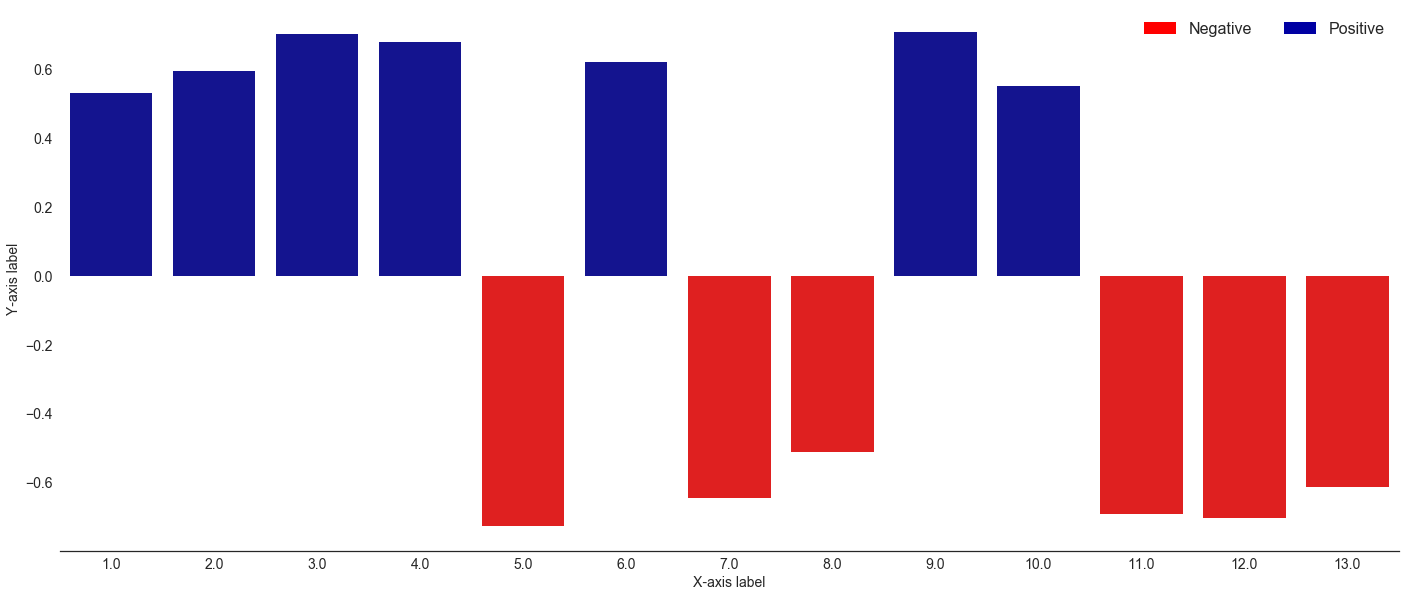

In [113]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

plot_sentiment('2 Corinthians')

In [97]:
def plot_sentiment(book_name):
    conn = sqlite3.connect('bible.db')
    c = conn.cursor()

    c.execute('select * from bible where book="{0}";'.format(book_name))
    all_rows = c.fetchall()
    conn.close()

    def zero_out(row):
        if row['pos'] > row['neg']:
            row['newpos'] = row['pos']
            row['newneg'] = 0
        else:
            row['newneg'] = row['neg'] * -1            
            row['newpos'] = 0
        return row

    # Histogram
    book = pd.DataFrame(all_rows, columns=['book','chap','verse','sentiment','pos','neg'])
    #print(book['pos'], book['neg'])
    
    #book['neg'] *= -1
    #sns.distplot(book.pos, bins=20)

    book = book[['chap','pos','neg']].groupby('chap').median().reset_index()
    book = book.apply(zero_out, axis=1)
    
    #stacked_bar_data = pd.DataFrame([[1,.27,-.72],[2,.30,-.69],[3,.62,-.37],[4,.15,-.85]], columns=['chap','pos','neg'])
    stacked_bar_data = book
    #stacked_bar_data['total'] = stacked_bar_data.Pos + stacked_bar_data.Neg

    #Set general plot properties
    sns.set_style("white")
    sns.set_context({"figure.figsize": (24, 10)})

    #Plot 1 - background - "total" (top) series
    sns.barplot(x = stacked_bar_data.chap, y = stacked_bar_data.newneg, color = "red")

    #Plot 2 - overlay - "bottom" series
    bottom_plot = sns.barplot(x = stacked_bar_data.chap, y = stacked_bar_data.newpos, color = "#0000A3")

    bottombar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
    topbar = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor = 'none')
    l = plt.legend([bottombar, topbar], ['Negative', 'Positive'], loc=1, ncol = 2, prop={'size':16})
    l.draw_frame(False)

    #Optional code - Make plot look nicer
    sns.despine(left=True)
    bottom_plot.set_ylabel("Y-axis label")
    bottom_plot.set_xlabel("X-axis label")

    #Set fonts to consistent 16pt size
    for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
                 bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
        item.set_fontsize(14)
        